In [1]:
import os
import time
import argparse
import numpy as np
import scipy.io as sio
import matplotlib as mpl
import torch.utils.data as Data
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


import torch
import torch.nn as nn
from torch import optim
import torch.utils.data as Data
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix


from data_prepare import mirror_hsi
from data_prepare import choose_train_and_test
from data_prepare import choose_all_pixels, all_data
from data_prepare import train_and_test_data, train_and_test_label


from Utils import train, test, valid
from Utils import output_metric, plot_confusion_matrix
from Utils import list_to_colormap, classification_map, print_args
from capsvit import CapsViT, Margin_Recon_Loss


%matplotlib inline

In [2]:
parser = argparse.ArgumentParser("CapsViT")
parser.add_argument('--dataset', choices=['HU2013', 'Salinas', 'HongHu', 'KSC'], default='Salinas', help='dataset to use')
parser.add_argument('--seed', type=int, default=42, help='number of seed')
parser.add_argument('--batch_size', type=int, default=32, help='number of batch size')
parser.add_argument('--patch_size', type=int, default=15, help='size of patches')
parser.add_argument('--epoches', type=int, default=100, help='epoch number')
parser.add_argument('--learning_rate', type=float, default=1e-3, help='learning rate')
parser.add_argument('--gamma', type=float, default=0.99, help='gamma')
parser.add_argument('--weight_decay', type=float, default=0.001, help='weight_decay')
parser.add_argument('--train_number', type=int, default=10, help='num_train_per_class')
args = parser.parse_args(args=[])

In [3]:
# prepare data
data_path = os.path.join(os.getcwd(), 'dataset')

if args.dataset == 'HU2013':
    data = sio.loadmat(os.path.join(data_path, 'Houston.mat'))['Houston']
    label = sio.loadmat(os.path.join(data_path, 'Houston_gt.mat'))['Houston_gt']
elif args.dataset == 'HanChuan':
    data = sio.loadmat(os.path.join(data_path, 'WHU_Hi_HanChuan.mat'))['WHU_Hi_HanChuan']
    label = sio.loadmat(os.path.join(data_path, 'WHU_Hi_HanChuan_gt.mat'))['WHU_Hi_HanChuan_gt']
elif args.dataset == 'KSC':
    data = sio.loadmat(os.path.join(data_path, 'KSC.mat'))['KSC']
    label = sio.loadmat(os.path.join(data_path, 'KSC_gt.mat'))['KSC_gt']
elif args.dataset == 'Salinas':
    data = sio.loadmat(os.path.join(data_path, 'Salinas_corrected.mat'))['salinas_corrected']
    label = sio.loadmat(os.path.join(data_path, 'Salinas_gt.mat'))['salinas_gt']
else:
    raise ValueError("Unknown dataset")

num_classes = np.max(label)
print('The class numbers of the HSI data is:', num_classes)

The class numbers of the HSI data is: 16


In [4]:
shapeor = data.shape
data = data.reshape(np.prod(data.shape[:2]), np.prod(data.shape[2:]))

std_scaler = StandardScaler()
std_data = std_scaler.fit_transform(data)
data = std_data.reshape(shapeor)

In [5]:
def applyPCA(data, numComponents=30):
    new_data = np.reshape(data, (-1, data.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    new_data = pca.fit_transform(new_data)
    new_data = np.reshape(new_data, (data.shape[0], data.shape[1], numComponents))
    return new_data, pca

In [6]:
K = 15
data, pca = applyPCA(data, numComponents=K)

# data size
height, width, band = data.shape
print("height={0}, width={1}, band={2}".format(height, width, band))

height=512, width=217, band=15


## Dataloader Construction

In [7]:
mirror_data = mirror_hsi(height, width, band, data, patch_size=args.patch_size)

*******************************************************
patch_size : 15
mirror_data shape : [526, 231, 15]
*******************************************************


In [8]:
total_pos_train, total_pos_test, total_pos_valid, number_train, number_test, number_valid = choose_train_and_test(label, args.train_number, args.seed) 

x_train, x_test, x_valid = train_and_test_data(mirror_data, band, total_pos_train, total_pos_test, total_pos_valid, args.patch_size)
y_train, y_test, y_valid = train_and_test_label(number_train, number_test, number_valid, num_classes)

*******************************************************
x_train shape = (160, 15, 15, 15), type = float64
x_test  shape = (53969, 15, 15, 15), type = float64
x_valid  shape = (1600, 15, 15, 15), type = float64
*******************************************************
y_train: shape = (160,), type = int64
y_test: shape = (53969,), type = int64
y_valid: shape = (1600,), type = int64
*******************************************************


In [9]:
total_pos_train[:10]

array([[268,  24],
       [245,  47],
       [242,  56],
       [263,  38],
       [243,  49],
       [246,  49],
       [257,  21],
       [243,  45],
       [247,  36],
       [245,  51]])

In [10]:
# load data
x_train = torch.from_numpy(x_train.transpose(0, 3, 1, 2)).type(torch.FloatTensor)  # (90, 1, 7, 7, 176)
print(x_train.shape)
y_train = torch.from_numpy(y_train).type(torch.LongTensor)  # (13,)
train_label = Data.TensorDataset(x_train, y_train)

x_test = torch.from_numpy(x_test.transpose(0, 3, 1, 2)).type(torch.FloatTensor)  # (5198, 1, 7, 7, 176)
print(x_test.shape)
y_test = torch.from_numpy(y_test).type(torch.LongTensor)  # (5198,)
test_label = Data.TensorDataset(x_test, y_test)

x_valid = torch.from_numpy(x_valid.transpose(0, 3, 1, 2)).type(torch.FloatTensor)  # (5211, 1, 7, 7, 176)
print(x_valid.shape)
y_valid = torch.from_numpy(y_valid).type(torch.LongTensor)
valid_label = Data.TensorDataset(x_valid, y_valid)

train_loader = Data.DataLoader(train_label, batch_size=32, shuffle=True)
test_loader = Data.DataLoader(test_label, batch_size=128, shuffle=True)
valid_loader = Data.DataLoader(valid_label, batch_size=64, shuffle=True)

torch.Size([160, 15, 15, 15])
torch.Size([53969, 15, 15, 15])
torch.Size([1600, 15, 15, 15])


## Model

In [11]:
model = CapsViT(band, caps2_caps=num_classes)

model = model.cuda()
# criterion
criterion = Margin_Recon_Loss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=args.gamma)

In [12]:
def model_summary(model):
    total_param = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            num_param = np.prod(param.size())
            if param.dim() > 1:
                print(name+':', 'x'.join(str(x) for x in list(param.size())), '=', num_param)
            else:
                print(name+':', num_param)
            total_param += num_param
    print("\nTotal Trainable Parameters:", total_param)

In [13]:
model_summary(model)

preliminary_layer.0.weight: 128x15x5x5 = 48000
preliminary_layer.0.bias: 128
preliminary_layer.1.weight: 128
preliminary_layer.1.bias: 128
preliminary_layer.3.weight: 96x128x3x3 = 110592
preliminary_layer.3.bias: 96
preliminary_layer.4.weight: 96
preliminary_layer.4.bias: 96
convgru.cell0.Wxz.weight: 12x12x3x3 = 1296
convgru.cell0.Wxz.bias: 12
convgru.cell0.Whz.weight: 12x12x3x3 = 1296
convgru.cell0.Wxr.weight: 12x12x3x3 = 1296
convgru.cell0.Wxr.bias: 12
convgru.cell0.Whr.weight: 12x12x3x3 = 1296
convgru.cell0.Wxg.weight: 12x12x3x3 = 1296
convgru.cell0.Wxg.bias: 12
convgru.cell0.Whg.weight: 12x12x3x3 = 1296
convgru.cell1.Wxz.weight: 6x12x3x3 = 648
convgru.cell1.Wxz.bias: 6
convgru.cell1.Whz.weight: 6x6x3x3 = 324
convgru.cell1.Wxr.weight: 6x12x3x3 = 648
convgru.cell1.Wxr.bias: 6
convgru.cell1.Whr.weight: 6x6x3x3 = 324
convgru.cell1.Wxg.weight: 6x12x3x3 = 648
convgru.cell1.Wxg.bias: 6
convgru.cell1.Whg.weight: 6x6x3x3 = 324
group_normalization.weight: 48
group_normalization.bias: 48
prim

In [14]:
print('start training')
acc_list = [0.00]
path = './model/capsvit.pt'
tic = time.time()
for epoch in range(args.epoches):
    # 计算的是移动平均准确率
    train_acc, train_loss = train(model, train_loader, criterion, optimizer)
    valid_acc, valid_loss = valid(model, valid_loader, criterion)
    print("Epoch: {:03d} - train_loss: {:.4f} - train_acc: {:.4f} - valid_loss: {:.4f} - valid_acc: {:.4f}".\
          format(epoch+1, train_loss, train_acc, valid_loss, valid_acc))
    scheduler.step()

    acc_list.append(valid_acc)
    if acc_list[-1] > acc_list[-2]:
        print("val_acc improved from {:.4f} to {:.4f}, saving model to capsvit.pt".format(acc_list[-2], acc_list[-1]))
        torch.save(model.state_dict(), path)
    else:
        print("val_acc did not improve from {:.4f}".format(acc_list[-2]))
        acc_list[-1] = acc_list[-2]

toc = time.time()
print("Running Time: {:.2f}".format(toc-tic))
print("**************************************************")

start training
Epoch: 001 - train_loss: 0.7000 - train_acc: 4.3750 - valid_loss: 0.6250 - valid_acc: 6.2500
val_acc improved from 0.0000 to 6.2500, saving model to capsvit.pt
Epoch: 002 - train_loss: 0.6063 - train_acc: 9.3750 - valid_loss: 0.5424 - valid_acc: 15.4375
val_acc improved from 6.2500 to 15.4375, saving model to capsvit.pt
Epoch: 003 - train_loss: 0.5418 - train_acc: 20.0000 - valid_loss: 0.4801 - valid_acc: 31.7500
val_acc improved from 15.4375 to 31.7500, saving model to capsvit.pt
Epoch: 004 - train_loss: 0.4783 - train_acc: 32.5000 - valid_loss: 0.4237 - valid_acc: 32.9375
val_acc improved from 31.7500 to 32.9375, saving model to capsvit.pt
Epoch: 005 - train_loss: 0.4078 - train_acc: 41.2500 - valid_loss: 0.3801 - valid_acc: 46.7500
val_acc improved from 32.9375 to 46.7500, saving model to capsvit.pt
Epoch: 006 - train_loss: 0.3665 - train_acc: 50.0000 - valid_loss: 0.3412 - valid_acc: 49.3125
val_acc improved from 46.7500 to 49.3125, saving model to capsvit.pt
Epoch: 

In [15]:
model.load_state_dict(torch.load(path))
model.eval()

tar_test, pre_test = test(model, test_loader)
OA_test, AA_mean_test, Kappa_test, AA_test = output_metric(tar_test, pre_test)
AA_test = np.around(AA_test*100, 2)

In [16]:
print("*******************************************************************")
print("Final result:")
print("OA: {:.2f}, AA: {:.2f}, Kappa: {:.4f}".format(OA_test * 100., AA_mean_test*100., Kappa_test))
print("*******************************************************************")
print("Recal: {}".format(AA_test))
print("*******************************************************************")
print("Parameter:")
print_args(vars(args))
print("*******************************************************************")

*******************************************************************
Final result:
OA: 93.46, AA: 97.44, Kappa: 0.9274
*******************************************************************
Recal: [100.   100.   100.    99.93  98.01 100.    99.02  78.2  100.    96.48
 100.   100.   100.   100.    88.21  99.22]
*******************************************************************
Parameter:
dataset: Salinas
seed: 42
batch_size: 32
patch_size: 15
epoches: 100
learning_rate: 0.001
gamma: 0.99
weight_decay: 0.001
train_number: 10
*******************************************************************


In [17]:
average_accuracy = str(list(AA_test))
file_name = "./CR/capsvit_1.txt"

with open(file_name, 'w') as x_file:
    x_file.write("[{:.2f}, {:.2f}, {:.4f}]".format(OA_test * 100., AA_mean_test*100., Kappa_test))
    x_file.write('\n')
    x_file.write('{}'.format(average_accuracy))

## Panoramic Classification

In [18]:
pos_forward, pos_backward = choose_all_pixels(label)

x_forward, x_backward, y_forward, y_backward = all_data(mirror_data, band, pos_forward, pos_backward, patch_size=args.patch_size)

*******************************************************
x_forward shape = (54129, 15, 15, 15), type = float64
x_backward  shape = (56975, 15, 15, 15), type = float64
*******************************************************


In [19]:
# load data
x_forward = torch.from_numpy(x_forward.transpose(0, 3, 1, 2)).type(torch.FloatTensor)
print(x_forward.shape)
y_forward = torch.from_numpy(y_forward).type(torch.LongTensor)  # (13,)
forward_label = Data.TensorDataset(x_forward, y_forward)

x_backward = torch.from_numpy(x_backward.transpose(0, 3, 1, 2)).type(torch.FloatTensor)
print(x_backward.shape)
y_backward = torch.from_numpy(y_backward).type(torch.LongTensor)  # (13,)
backward_label = Data.TensorDataset(x_backward, y_backward)

forward_loader = Data.DataLoader(forward_label, batch_size=128, shuffle=False)
backward_loader = Data.DataLoader(backward_label, batch_size=128, shuffle=False)

torch.Size([54129, 15, 15, 15])
torch.Size([56975, 15, 15, 15])


In [20]:
# output classification maps
_, pre_forward = test(model, forward_loader)
_, pre_backward = test(model, backward_loader)

prediction_matrix = np.zeros((height, width), dtype=float)  # (512, 614)
for i in range(pos_forward.shape[0]):
    prediction_matrix[pos_forward[i, 0], pos_forward[i, 1]] = pre_forward[i] + 1

for j in range(pos_backward.shape[0]):
    prediction_matrix[pos_backward[j, 0], pos_backward[j, 1]] = pre_backward[j] + 1

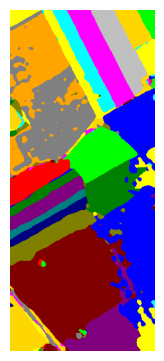

In [21]:
predict_map = list_to_colormap(prediction_matrix.ravel())
predict_map = np.reshape(predict_map, (height, width, 3))

classification_map(predict_map, './salinas_capsvit.pdf')